In [1]:
# %%
import sys
import os
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet

from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid

In [2]:
saveroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
savedir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn"

In [3]:
with open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "rb") as f:
    data = pkl.load(f)
diag_cov_x_sample_true_eigenbasis_traj = data["diag_cov_x_sample_true_eigenbasis_traj"]
mean_x_sample_traj = data["mean_x_sample_traj"]
cov_x_sample_traj = data["cov_x_sample_traj"]
true_cov_eigs = data["true_cov_eigs"]
step_slice = data["step_slice"]

In [10]:
with open(f"{savedir}/train_data_cov_info.pkl", "rb") as f:
    data = pkl.load(f)
Xtsr = data["train_pnts"]
X_mean = data["X_mean"]
rot = data["rot"]
diag_var = data["diag_var"]
cov_empirical = data["cov_empirical"]
ndim = Xtsr.shape[1]

In [17]:
with open(f"{savedir}/sample_store.pkl", "rb") as f:
    sample_store = pkl.load(f)

### Whole image statistics

In [12]:
device = "cuda"

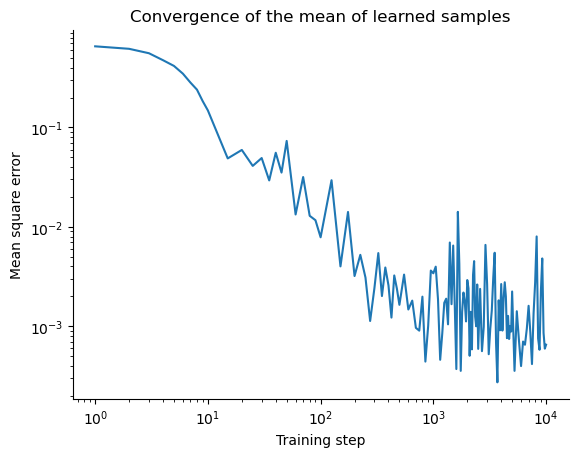

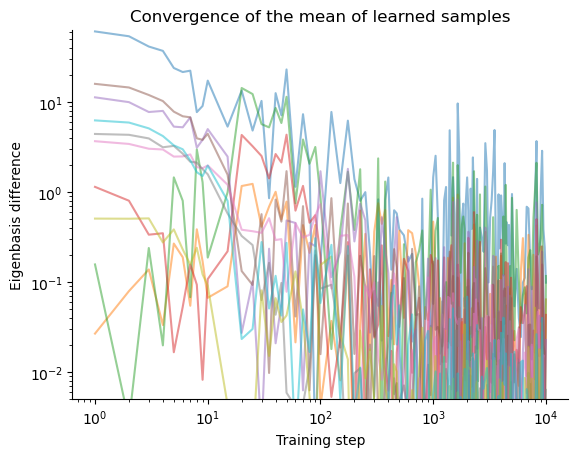

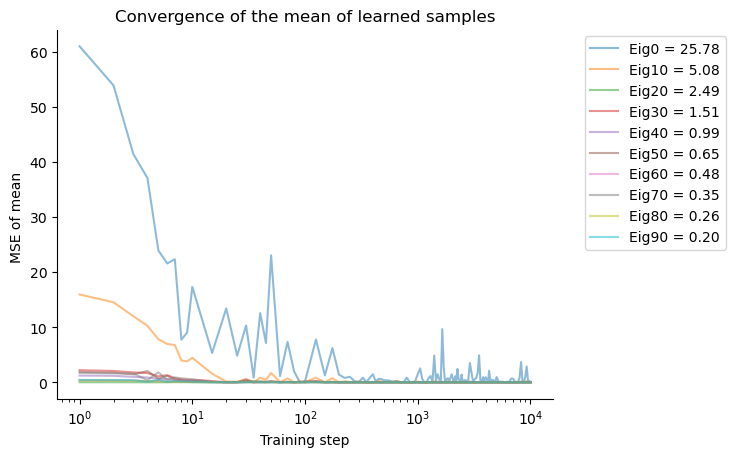

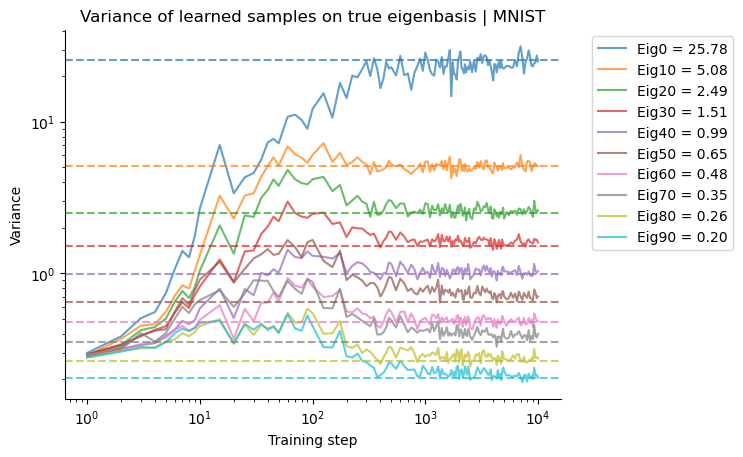

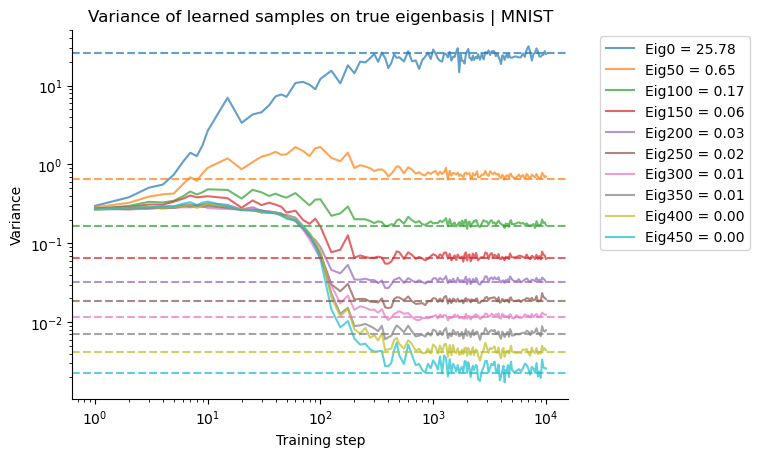

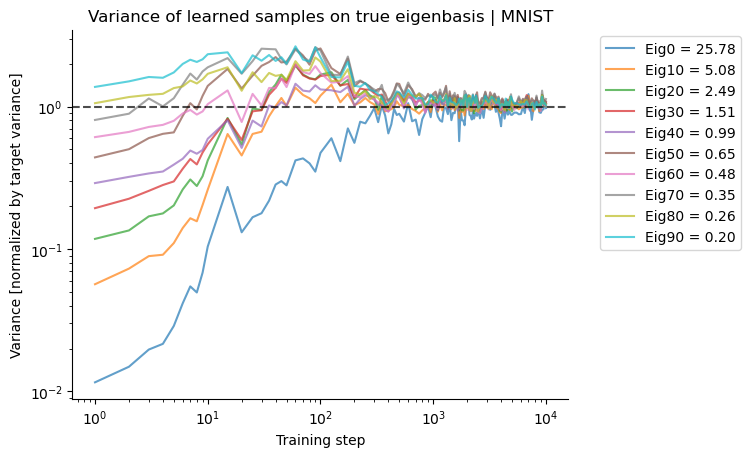

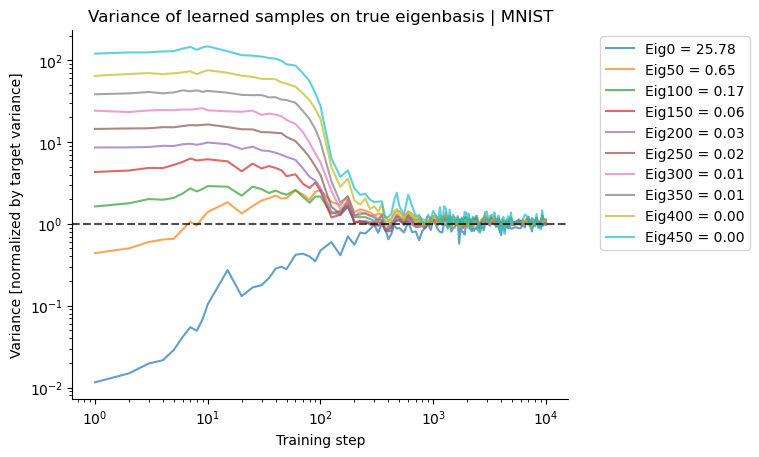

In [15]:

# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.to(device) - X_mean.to(device)).pow(2).mean(dim=1)
plt.figure()
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj_loglog")
plt.show()

# %%
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean.to(device)) @ rot.to(device)
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top20_loglog")
plt.show()

# %%
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean.to(device)) @ rot.to(device)
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.figure()
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top500")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()

# %%
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.figure()
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top500")
plt.show()

### Patch statisics 


In [ ]:
def extract_patches(images, patch_size, patch_stride):
    B, C, H, W = images.shape
    patches = images.unfold(2, patch_size, patch_stride).unfold(3, patch_size, patch_stride)
    patches = patches.contiguous().view(B, C, -1, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4).contiguous().view(-1, C, patch_size, patch_size)
    return patches

images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=3, patch_stride=3)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

torch.Size([6000000, 1, 3, 3])

### Smallest patch 3x3 stride 1

In [40]:
patch_size, patch_stride = 3, 1
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)

imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

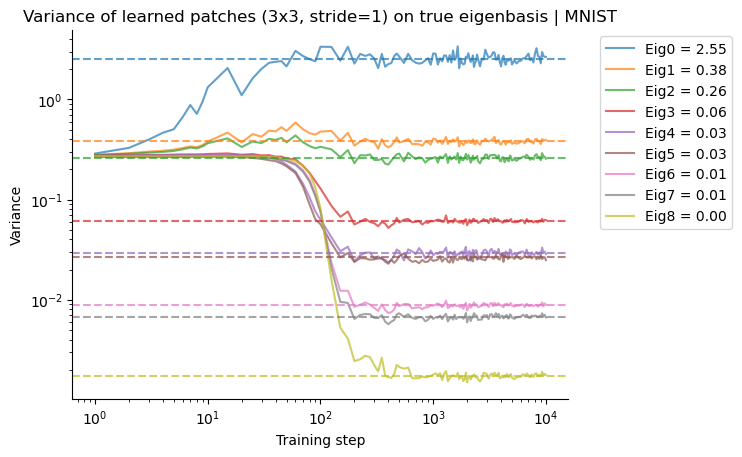

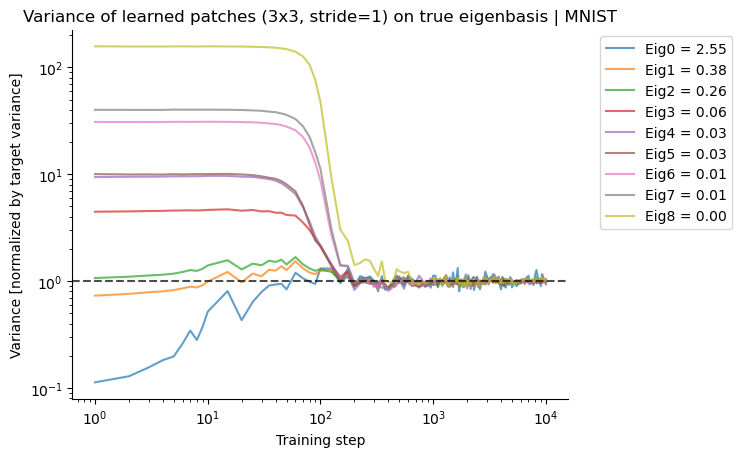

In [41]:
plt.figure()
slice2plot = slice(None, 9, 1)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
slice2plot = slice(None, 9, 1)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Smallest patch 3x3

In [35]:
patch_size, patch_stride = 3, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)

imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

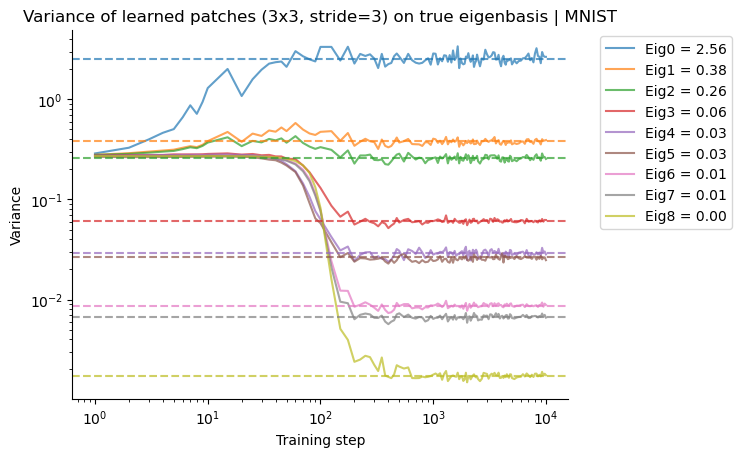

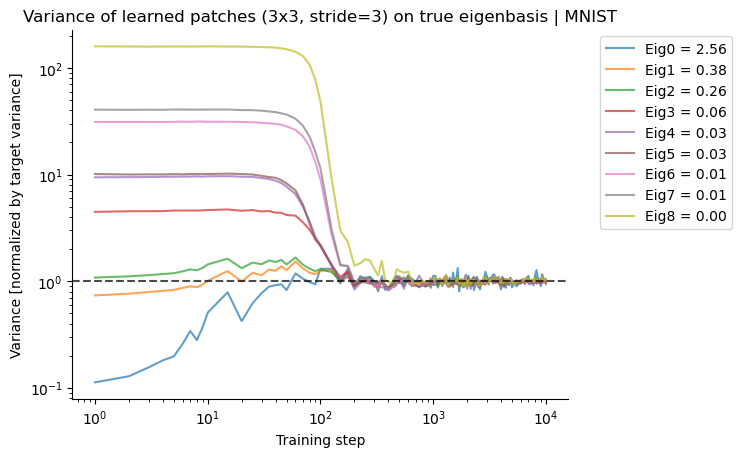

In [36]:
plt.figure()
slice2plot = slice(None, 9, 1)
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
slice2plot = slice(None, 9, 1)
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 6x6

In [31]:
patch_size, patch_stride = 6, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

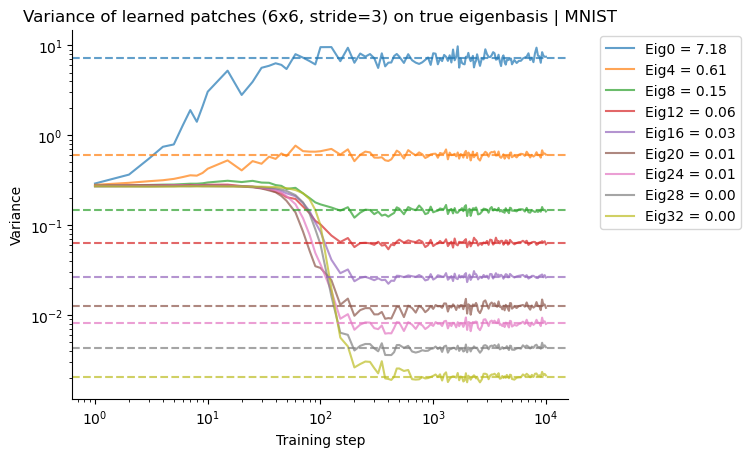

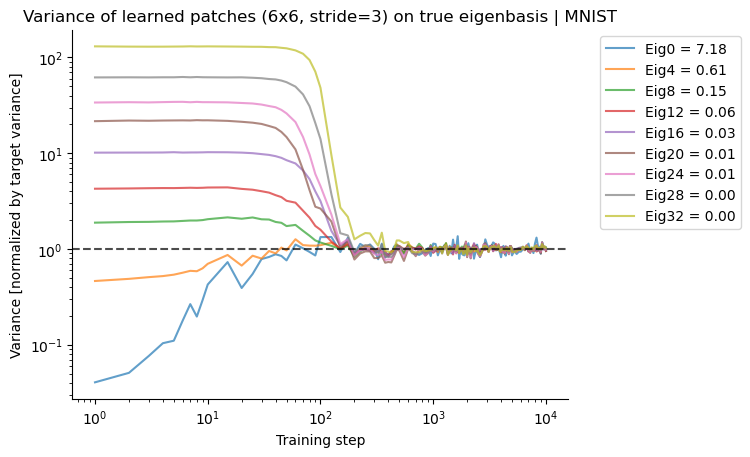

In [33]:

slice2plot = slice(None, 36, 4)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 9x9

In [37]:
patch_size, patch_stride = 9, 3
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

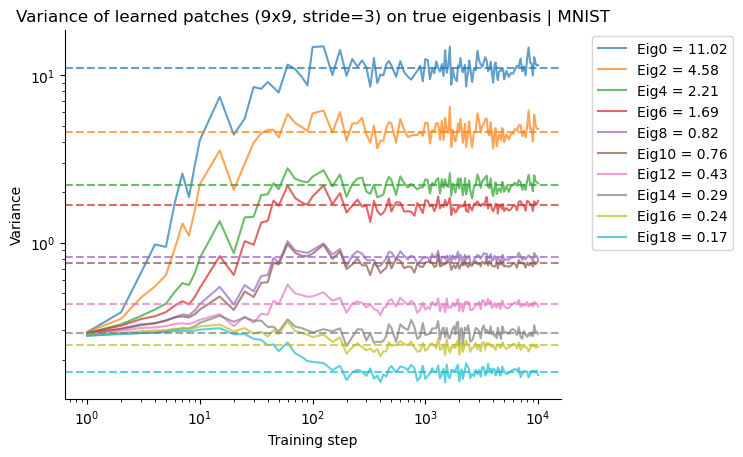

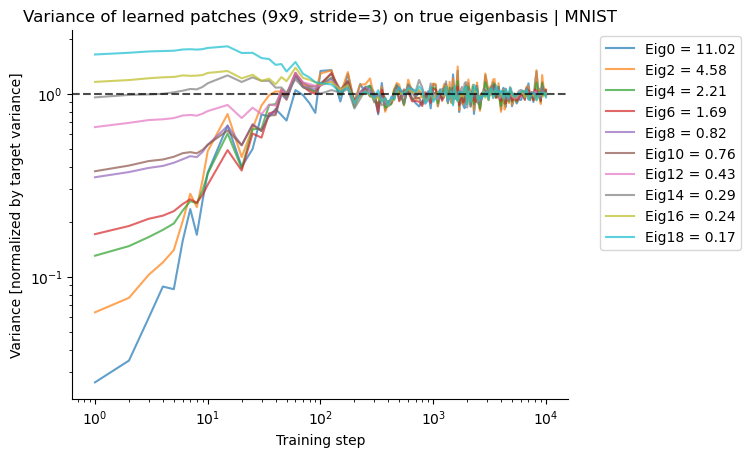

In [39]:
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top20")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top20")
plt.show()

In [46]:
savedir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn'

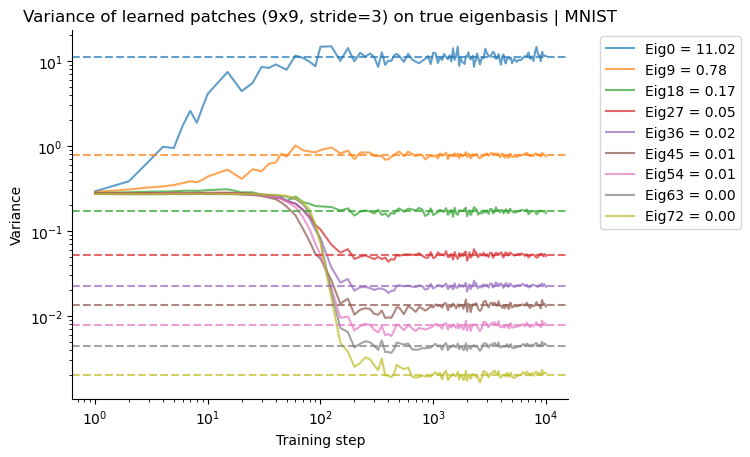

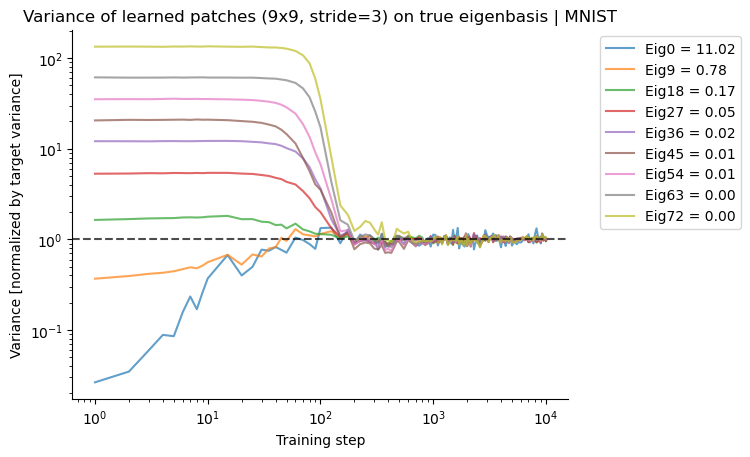

In [38]:
slice2plot = slice(None, 81, 9)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

### Larger patches 16x16

In [42]:
patch_size, patch_stride = 16, 4
images = Xtsr.view(Xtsr.shape[0], 1, 32, 32)
patches = extract_patches(images, patch_size=patch_size, patch_stride=patch_stride)
patch_shape = patches.shape[1:]
patch_dim = np.prod(patch_shape)

patch_cov = torch.cov(patches.view(patches.shape[0], -1).T)
patch_eigval, patch_eigvec = torch.linalg.eigh(patch_cov)
patch_eigval = patch_eigval.flip(0)
patch_eigvec = patch_eigvec.flip(1)
imgshape = (1, 32, 32)
true_cov_eigs = diag_var.cpu()
mean_x_patch_sample_traj = []
cov_x_patch_sample_traj = []
diag_cov_x_patch_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final_patches = extract_patches(x_final.view(x_final.shape[0], *imgshape), patch_size=patch_size, patch_stride=patch_stride)
    x_final_patches = x_final_patches.view(x_final_patches.shape[0], -1)
    mean_x_patch_sample = x_final_patches.mean(dim=0)
    cov_x_patch_sample = torch.cov(x_final_patches.T)
    mean_x_patch_sample_traj.append(mean_x_patch_sample.cpu())
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_patch_sample_true_eigenbasis = patch_eigvec.T @ cov_x_patch_sample @ patch_eigvec
    diag_cov_x_patch_sample_true_eigenbasis = torch.diag(cov_x_patch_sample_true_eigenbasis)
    diag_cov_x_patch_sample_true_eigenbasis_traj.append(diag_cov_x_patch_sample_true_eigenbasis.cpu())
    cov_x_patch_sample_traj.append(cov_x_patch_sample.cpu())
    
mean_x_patch_sample_traj = torch.stack(mean_x_patch_sample_traj).cpu()
cov_x_patch_sample_traj = torch.stack(cov_x_patch_sample_traj).cpu()
diag_cov_x_patch_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_patch_sample_true_eigenbasis_traj).cpu()

  0%|          | 0/124 [00:00<?, ?it/s]

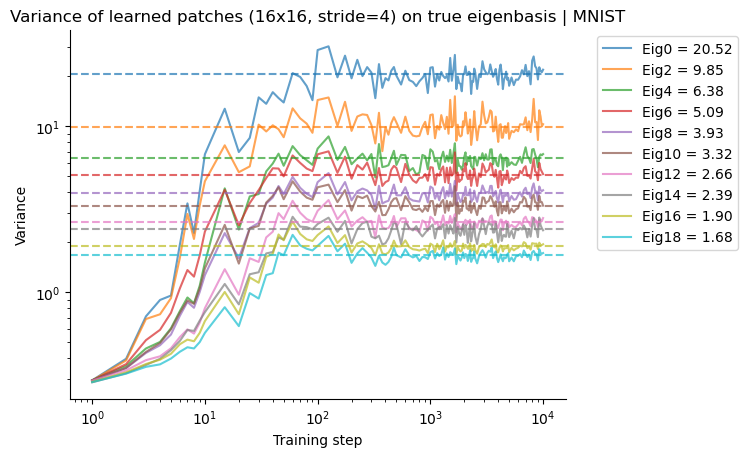

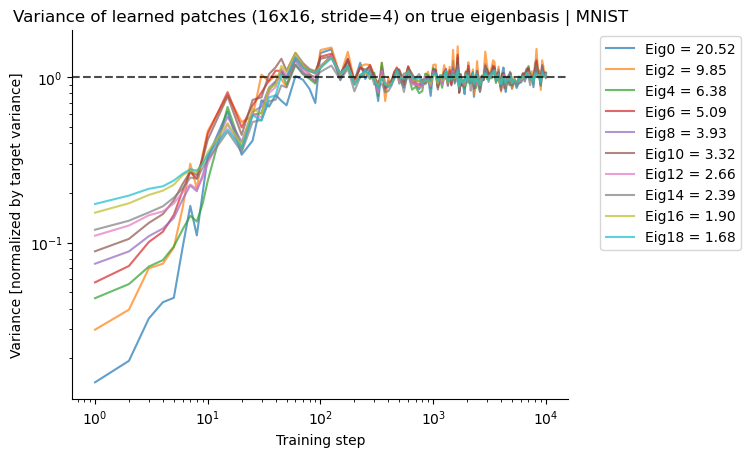

In [43]:
slice2plot = slice(None, 20, 2)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw_top20")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized_top20")
plt.show()

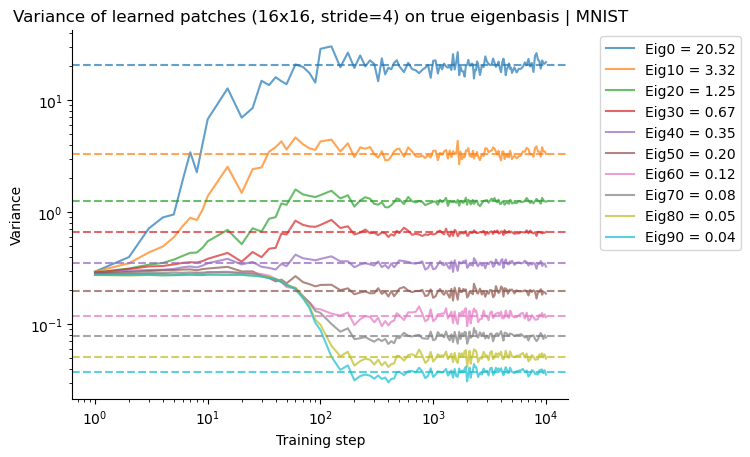

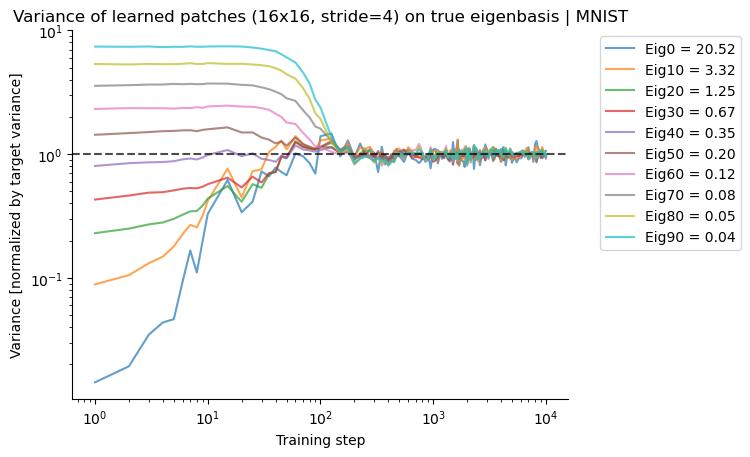

In [44]:
slice2plot = slice(None, 100, 10)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()

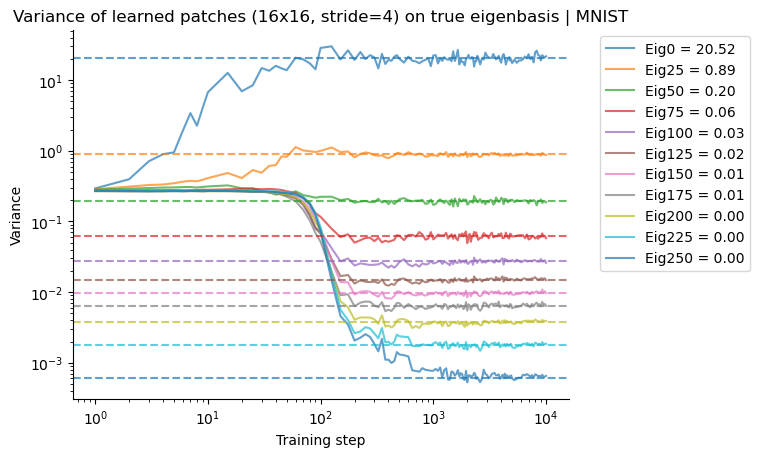

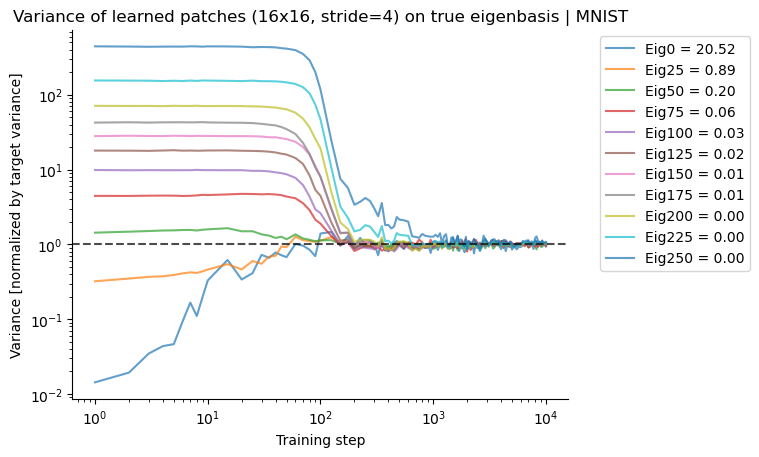

In [45]:
slice2plot = slice(None, 256, 25)
plt.figure()
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_raw")
plt.show()

plt.figure()
diag_cov_x_patch_sample_true_eigenbasis_traj_normalized = diag_cov_x_patch_sample_true_eigenbasis_traj / patch_eigval
plt.plot(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(patch_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.title(f"Variance of learned patches ({patch_size}x{patch_size}, stride={patch_stride}) on true eigenbasis | MNIST")
plt.gca().legend([f"Eig{i} = {patch_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, f"sample_patch_{patch_size}x{patch_size}_stride_{patch_stride}_cov_true_eigenbasis_diag_traj_normalized")
plt.show()